# Plotting PPO agent with dietkit data

In [1]:
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
import numpy as np
import pandas as pd
from meal_planning_environment import MealPlanningEnv
from dietkit import load_ingredient, load_menu, load_diet
import matplotlib.pyplot as plt

import os 
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common.noise import NormalActionNoise
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common import results_plotter

log_dir = "/tmp/gym/"
os.makedirs(log_dir, exist_ok=True)


In [2]:
all_ingredients = load_ingredient(sample_language = 'eng')
meal_dict = load_menu(ingredients = all_ingredients, sample_language = 'eng')
example_mealplans = load_diet(menus = meal_dict, num_loads = 100, sample_language = 'eng', sample_name = 'ML')

possible_meals = np.array(list(meal_dict.keys()))
display(possible_meals)

nutrition_data = pd.DataFrame([meal.nutrition for meal in meal_dict.values()], index=possible_meals)
display(nutrition_data)

array(['S watermelon punch (without milks)', 'Dried persimmon',
       'S kyogo grape (100g)', ..., 'Green onion kimchi',
       'Pickled paprika', 'empty'], dtype='<U72')

,Energy,Protein,Fat,Carbohydrate,Total Dietary,Calcium,Iron,Sodium,Vitamin A,Vitamin B1 (Thiamine),Vitamin B2 (Rivoflavin),Vitamin C,Linoleic Acid,Alpha-Linolenic Acid
S watermelon punch (without milks),55.00,0.7900,0.05000,13.8180,0.200,7.200,0.18600,0.600,71.083333,0.024000,0.03000,0.0000,14.2500,2.9300
Dried persimmon,76.50,0.5820,0.04800,20.5830,3.360,6.300,0.19200,0.900,13.725000,0.003000,0.06720,1.5330,0.0000,8.6010
S kyogo grape (100g),61.00,0.4300,0.04000,16.3800,0.400,4.000,0.17000,1.000,2.166667,0.026000,0.04700,0.1300,11.8900,6.0900
S dried persimmon,85.60,0.7720,0.03200,22.9800,3.400,5.600,0.24800,0.400,9.533333,0.003600,0.09720,1.0680,0.0000,5.0440
S fruit punch,101.05,3.6700,3.36450,14.8900,0.790,117.650,0.19850,36.000,91.166667,0.040350,0.19110,1.8925,86.6605,10.6925
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Ponytail radish kimchi,10.25,0.5050,0.05000,1.9725,0.775,10.500,0.16750,173.000,5.541667,0.003250,0.01900,0.4125,19.7050,9.4775
Kohlrabi watery kimchi,5.50,0.2900,0.01250,1.2900,0.600,10.500,0.06750,1.750,0.250000,0.203750,0.00875,0.0000,1.9650,5.1100
Green onion kimchi,12.25,0.6250,0.14500,2.1275,1.150,15.000,0.18250,163.750,26.854167,0.012750,0.02850,0.5550,79.8050,17.1425
Pickled paprika,7.94,0.2017,0.03005,1.9859,0.348,1.675,0.08145,67.204,4.850000,0.003675,0.02709,24.2820,12.4483,6.5448


In [3]:
class SaveOnBestTrainingRewardCallback(BaseCallback):
    """
    Callback for saving a model (the check is done every ``check_freq`` steps)
    based on the training reward (in practice, we recommend using ``EvalCallback``).

    :param check_freq: (int)
    :param log_dir: (str) Path to the folder where the model will be saved.
      It must contains the file created by the ``Monitor`` wrapper.
    :param verbose: (int)
    """

    def __init__(self, check_freq: int, log_dir: str, verbose=1):
        super().__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, "best_model")
        self.best_mean_reward = -np.inf

    def _init_callback(self) -> None:
        # Create folder if needed
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:

            # Retrieve training reward
            x, y = ts2xy(load_results(self.log_dir), "timesteps")
            if len(x) > 0:
                # Mean training reward over the last 100 episodes
                mean_reward = np.mean(y[-100:])
                if self.verbose > 0:
                    print(f"Num timesteps: {self.num_timesteps}")
                    print(
                        f"Best mean reward: {self.best_mean_reward:.2f} - Last mean reward per episode: {mean_reward:.2f}"
                    )

                # New best model, you could save the agent here
                if mean_reward > self.best_mean_reward:
                    self.best_mean_reward = mean_reward
                    # Example for saving best model
                    if self.verbose > 0:
                        print(f"Saving new best model to {self.save_path}.zip")
                    self.model.save(self.save_path)

        return True

def moving_average(values, window):
    """
    Smooth values by doing a moving average
    :param values: (numpy array)
    :param window: (int)
    :return: (numpy array)
    """
    weights = np.repeat(1.0, window) / window
    return np.convolve(values, weights, "valid")


def plot_results(log_folder, title="Learning Curve"):
    """
    plot the results

    :param log_folder: (str) the save location of the results to plot
    :param title: (str) the title of the task to plot
    """
    x, y = ts2xy(load_results(log_folder), "timesteps")
    y = moving_average(y, window=50)
    # Truncate x
    x = x[len(x) - len(y) :]

    fig = plt.figure(title)
    plt.plot(x, y)
    plt.xlabel("Number of Timesteps")
    plt.ylabel("Rewards")
    plt.title(title + " Smoothed")
    plt.show()

Using cpu device
Wrapping the env in a DummyVecEnv.
Step: 1
Chosen Meal: Dried shrimp spinach soup
Meal History: ['Dried shrimp spinach soup']
Nutrition History: [[2.5670e+01 3.6900e+00 4.8000e-01 1.8400e+00 4.0000e-02 1.7627e+02
  1.6900e+00 3.3939e+02 2.1500e+00 7.0000e-02 4.0000e-02 1.1800e+00
  1.9700e+00 9.0000e-01]]
Goal Nutrition: [8.3530e+01 4.2000e+00 2.6900e+00 1.0510e+01 7.9000e-01 3.0970e+01
 6.9000e-01 1.3005e+02 2.6570e+01 6.0000e-02 8.0000e-02 3.8800e+00
 6.8505e+02 9.5640e+01]
Current Nutrition: [2.5670e+01 3.6900e+00 4.8000e-01 1.8400e+00 4.0000e-02 1.7627e+02
 1.6900e+00 3.3939e+02 2.1500e+00 7.0000e-02 4.0000e-02 1.1800e+00
 1.9700e+00 9.0000e-01]
Reward: 555.3855246666001
Num timesteps: 1000
Best mean reward: -inf - Last mean reward per episode: 0.00
Saving new best model to /tmp/gym/best_model.zip
Num timesteps: 2000
Best mean reward: 0.00 - Last mean reward per episode: 0.00
---------------------------------
| rollout/           |          |
|    ep_len_mean     |

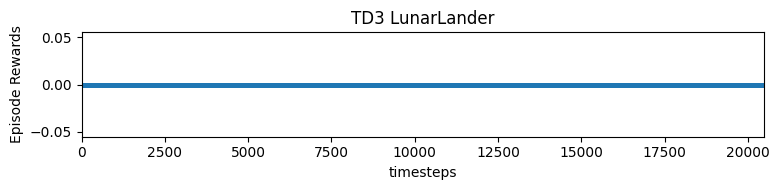

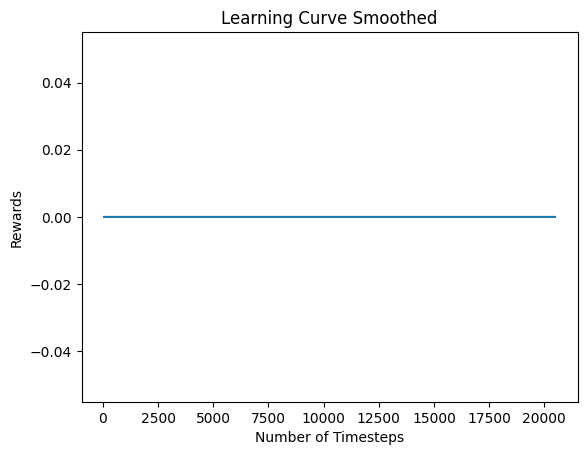

In [4]:
num_meals = 1
env = MealPlanningEnv(possible_meals=possible_meals, nutrition_data=nutrition_data, num_meals=num_meals)

# Logs will be saved in log_dir/monitor.csv
env = Monitor(env, log_dir)
callback = SaveOnBestTrainingRewardCallback(check_freq=1000, log_dir=log_dir)

model = PPO("MultiInputPolicy", env, verbose=1)
obs = env.reset()
for i in range(num_meals):
  action, _ = model.predict(obs)
  obs, rewards, done, info = env.step(action)
env.render()
model.learn(total_timesteps=20000, callback=callback)

obs = env.reset()
for i in range(num_meals):
  action, _ = model.predict(obs)
  obs, rewards, done, info = env.step(action)
  action, _states = model.predict(obs)
  # print(action)
  
 
env.render()

# Helper from the library
results_plotter.plot_results(
    [log_dir], 1e5, results_plotter.X_TIMESTEPS, "TD3 LunarLander"
)

plot_results(log_dir)